### importing libraries

In [40]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F
from pyspark.ml.feature import StringIndexer,OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors

### starting a spark session

In [4]:
spark = SparkSession.builder.appName('my_app').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/10 12:09:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### loading the data

In [5]:
file_loc = "/kaggle/input/powerlifting-data/powerlifting_dataset.csv"
data = spark.read.csv(file_loc,header=True,inferSchema=True)

### top five rows

In [6]:
data.show(5)

+--------------+---+------------+-----------+------------------+
|   Lifter Name|Age|Weight Class|  Lift Type|Amount Lifted (kg)|
+--------------+---+------------+-----------+------------------+
|Jessica Wilson| 46|       59 kg|Bench Press|               269|
|      John Doe| 60|       83 kg|Bench Press|               179|
|   Emily Davis| 41|      105 kg|Bench Press|               235|
|   Emily Davis| 33|       66 kg|      Squat|               359|
|  Laura Taylor| 56|       74 kg|   Deadlift|               221|
+--------------+---+------------+-----------+------------------+
only showing top 5 rows



In [7]:
data.columns

['Lifter Name', 'Age', 'Weight Class', 'Lift Type', 'Amount Lifted (kg)']

In [8]:
data = data.drop('Lifter Name')

### Age: The age of the lifter.
### Weight Class: The competitive weight class of the lifter.
### Lift Type: The type of lift performed, such as Squat, Bench Press, or Deadlift.
### Amount Lifted (kg): The weight lifted by the powerlifter, measured in kilograms.

In [9]:
data.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Weight Class: string (nullable = true)
 |-- Lift Type: string (nullable = true)
 |-- Amount Lifted (kg): integer (nullable = true)



### checking and dropping duplicates

In [10]:
no_of_duplicates = data.groupBy(data.columns).count().filter(F.col('count') > 1).count()
print(f"Number of duplicate rows: {no_of_duplicates}")

Number of duplicate rows: 11


In [11]:
data = data.dropDuplicates()

### checking null values

In [12]:
null_values = data.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in data.columns])
null_values.show()

+---+------------+---------+------------------+
|Age|Weight Class|Lift Type|Amount Lifted (kg)|
+---+------------+---------+------------------+
|  0|           0|        0|                 0|
+---+------------+---------+------------------+



### statistical summary of the data

In [13]:
data.describe().show()

24/08/10 12:10:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------+-----------+------------------+
|summary|               Age|Weight Class|  Lift Type|Amount Lifted (kg)|
+-------+------------------+------------+-----------+------------------+
|  count|              2989|        2989|       2989|              2989|
|   mean| 41.03579792572767|        NULL|       NULL| 250.3422549347608|
| stddev|13.675885440351784|        NULL|       NULL| 86.21941452382151|
|    min|                18|      105 kg|Bench Press|               100|
|    max|                64|        Open|      Squat|               399|
+-------+------------------+------------+-----------+------------------+



### let's rename the columns

In [14]:
data = data.withColumnRenamed('Age','age')
data = data.withColumnRenamed('Weight Class','class')
data = data.withColumnRenamed('Lift Type','type')
data = data.withColumnRenamed('Amount Lifted (kg)','lifted')
data.columns

['age', 'class', 'type', 'lifted']

### doing visualizations

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

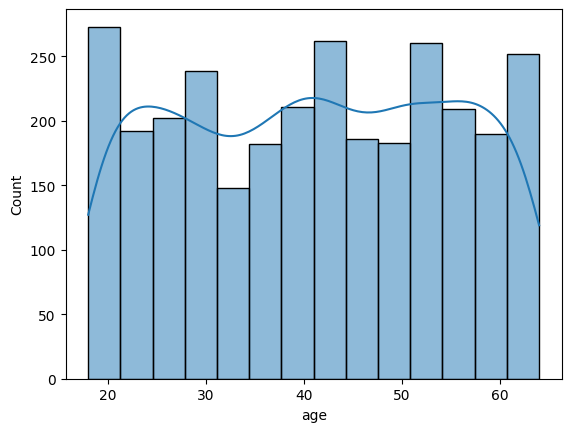

In [15]:
pandas_data = data.toPandas() # we first convert the data to pandas df since seaborn and matplotlib works well with pandas df
sns.histplot(x=pandas_data['age'],kde=True)

<Axes: xlabel='age'>

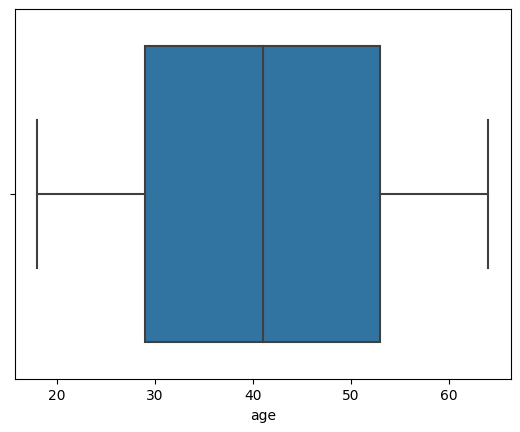

In [16]:
sns.boxplot(x=pandas_data['age'])

In [17]:
data.groupBy('class').count().orderBy(F.col('count').desc()).show()

+------+-----+
| class|count|
+------+-----+
|  Open|  355|
| 93 kg|  355|
| 59 kg|  347|
| 83 kg|  327|
| 66 kg|  325|
| 52 kg|  324|
| 74 kg|  320|
|120 kg|  319|
|105 kg|  317|
+------+-----+



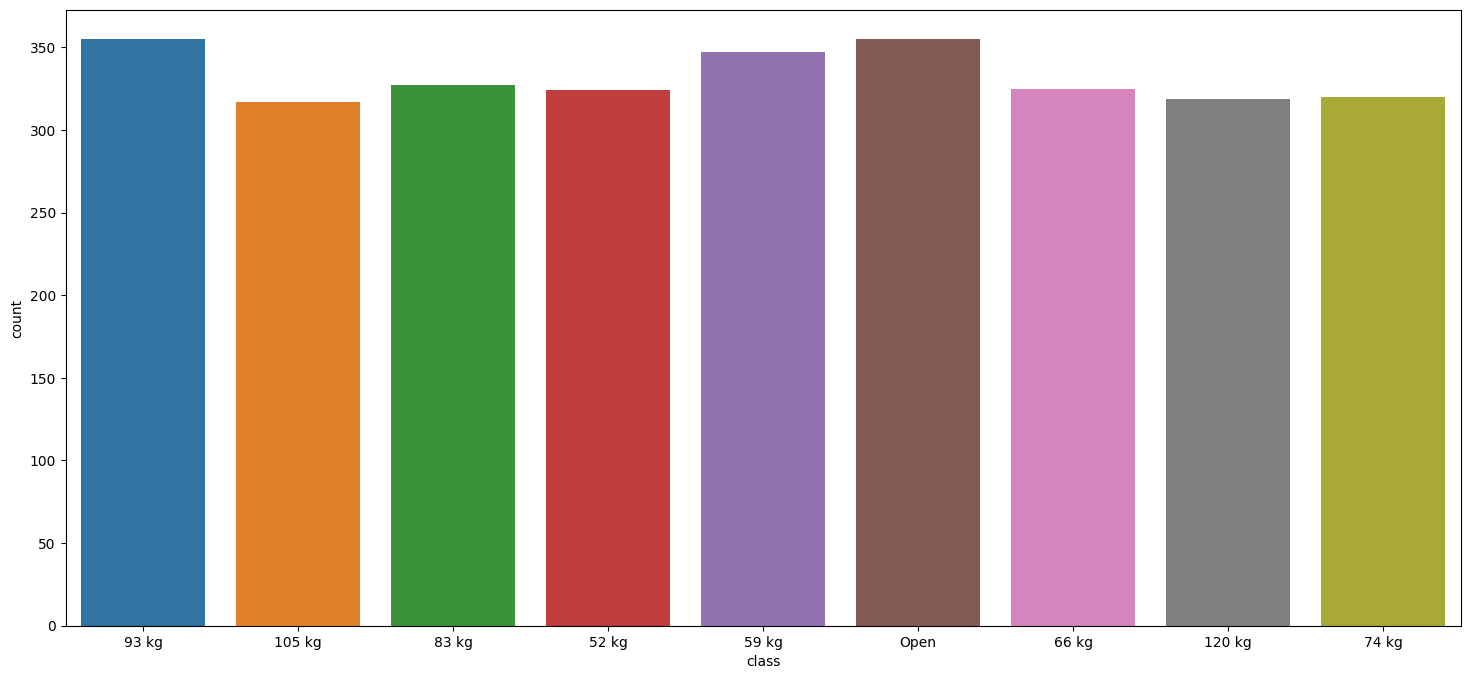

In [18]:
plt.figure(figsize=(18,8))
sns.countplot(x=pandas_data['class'])
plt.show()

In [19]:
data.groupBy('type').count().orderBy(F.col('count').desc()).show()

+-----------+-----+
|       type|count|
+-----------+-----+
|   Deadlift| 1021|
|Bench Press| 1009|
|      Squat|  959|
+-----------+-----+



<Axes: xlabel='type', ylabel='count'>

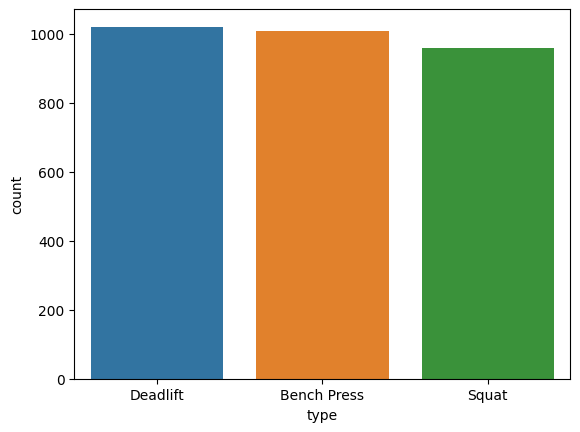

In [20]:
sns.countplot(x=pandas_data['type'])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='lifted', ylabel='Count'>

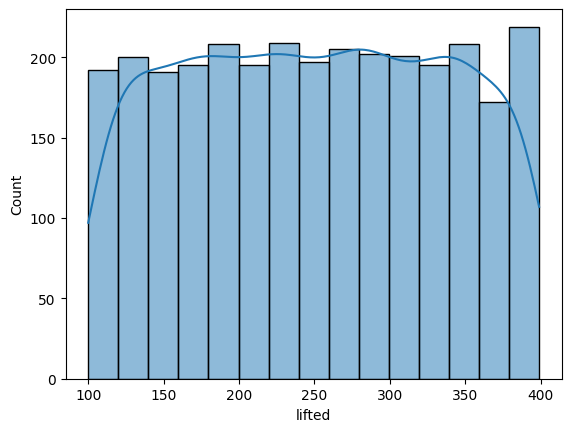

In [21]:
sns.histplot(x=pandas_data['lifted'],kde=True)

<Axes: xlabel='lifted'>

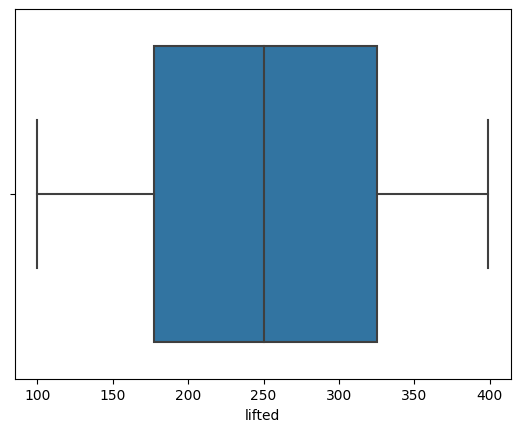

In [22]:
sns.boxplot(x=pandas_data['lifted'])

In [23]:
data.show(5)

+---+------+-----------+------+
|age| class|       type|lifted|
+---+------+-----------+------+
| 57| 93 kg|   Deadlift|   327|
| 37| 93 kg|   Deadlift|   214|
| 31|105 kg|Bench Press|   313|
| 42| 83 kg|   Deadlift|   224|
| 55| 52 kg|   Deadlift|   281|
+---+------+-----------+------+
only showing top 5 rows



### converting cat. values to num. values

In [24]:
indexer = StringIndexer(inputCol="class", outputCol="lift_class") # converts to label encoded values
data = indexer.fit(data).transform(data)

In [25]:
data.show(5)

+---+------+-----------+------+----------+
|age| class|       type|lifted|lift_class|
+---+------+-----------+------+----------+
| 57| 93 kg|   Deadlift|   327|       0.0|
| 37| 93 kg|   Deadlift|   214|       0.0|
| 31|105 kg|Bench Press|   313|       8.0|
| 42| 83 kg|   Deadlift|   224|       3.0|
| 55| 52 kg|   Deadlift|   281|       5.0|
+---+------+-----------+------+----------+
only showing top 5 rows



In [26]:
indexer2 = StringIndexer(inputCol="type", outputCol="lift_type")
data = indexer2.fit(data).transform(data)

In [27]:
data.show(5)

+---+------+-----------+------+----------+---------+
|age| class|       type|lifted|lift_class|lift_type|
+---+------+-----------+------+----------+---------+
| 57| 93 kg|   Deadlift|   327|       0.0|      0.0|
| 37| 93 kg|   Deadlift|   214|       0.0|      0.0|
| 31|105 kg|Bench Press|   313|       8.0|      1.0|
| 42| 83 kg|   Deadlift|   224|       3.0|      0.0|
| 55| 52 kg|   Deadlift|   281|       5.0|      0.0|
+---+------+-----------+------+----------+---------+
only showing top 5 rows



In [28]:
data = data.drop('class','type')
data.show(5)

+---+------+----------+---------+
|age|lifted|lift_class|lift_type|
+---+------+----------+---------+
| 57|   327|       0.0|      0.0|
| 37|   214|       0.0|      0.0|
| 31|   313|       8.0|      1.0|
| 42|   224|       3.0|      0.0|
| 55|   281|       5.0|      0.0|
+---+------+----------+---------+
only showing top 5 rows



In [29]:
data.columns

['age', 'lifted', 'lift_class', 'lift_type']

### creating input features in form of alist

In [30]:
assembler = VectorAssembler(
    inputCols=['age','lift_class','lift_type'],
    outputCol='inp_features'
)

In [31]:
new_data = assembler.transform(data)

In [32]:
new_data.show(5)

+---+------+----------+---------+--------------+
|age|lifted|lift_class|lift_type|  inp_features|
+---+------+----------+---------+--------------+
| 57|   327|       0.0|      0.0|[57.0,0.0,0.0]|
| 37|   214|       0.0|      0.0|[37.0,0.0,0.0]|
| 31|   313|       8.0|      1.0|[31.0,8.0,1.0]|
| 42|   224|       3.0|      0.0|[42.0,3.0,0.0]|
| 55|   281|       5.0|      0.0|[55.0,5.0,0.0]|
+---+------+----------+---------+--------------+
only showing top 5 rows



In [33]:
final_data = new_data.select('inp_features','lifted')
final_data.show(5)

+--------------+------+
|  inp_features|lifted|
+--------------+------+
|[57.0,0.0,0.0]|   327|
|[37.0,0.0,0.0]|   214|
|[31.0,8.0,1.0]|   313|
|[42.0,3.0,0.0]|   224|
|[55.0,5.0,0.0]|   281|
+--------------+------+
only showing top 5 rows



### train test split

In [34]:
train_data, test_data = final_data.randomSplit([0.8, 0.2])

### model building

In [35]:
rf = RandomForestRegressor(featuresCol="inp_features", labelCol="lifted")
model = rf.fit(train_data)

### making predictions

In [36]:
predictions = model.transform(test_data)

### model evaluations

In [37]:
evaluator = RegressionEvaluator(labelCol="lifted", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 86.21290260835475


In [39]:
predictions.show(5)

+--------------+------+------------------+
|  inp_features|lifted|        prediction|
+--------------+------+------------------+
|[18.0,1.0,1.0]|   235|238.34780909387504|
|[18.0,1.0,2.0]|   357|235.82722220192022|
|[18.0,2.0,0.0]|   350|252.59501379286894|
|[18.0,2.0,0.0]|   375|252.59501379286894|
|[18.0,3.0,1.0]|   319| 261.8332642285028|
+--------------+------+------------------+
only showing top 5 rows



### making predictions on new data

In [41]:
inp = [57,0,0]
vector = Vectors.dense(inp)

In [42]:
input_df = spark.createDataFrame([(vector, )], ["inp_features"])
predictions = model.transform(input_df)
predictions.show()

+--------------+-----------------+
|  inp_features|       prediction|
+--------------+-----------------+
|[57.0,0.0,0.0]|244.6858095444705|
+--------------+-----------------+



### stopping spark session

In [43]:
spark.stop()